*@author Laura María Pedraza Gómez*

## Dataset Wine

**Importaciones iniciales**

In [317]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*X does not have valid feature names.*')

**Funciones**

In [319]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [320]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [321]:
def evaluate_result(y_pred, y, y_prep_pred, y_prep, metric):
    print(metric.__name__, "WITHOUT preparation:", metric(y_pred, y, average='weighted'))
    print(metric.__name__, "WITH preparation:", metric(y_prep_pred, y_prep, average='weighted'))

## Preparación de los datos

Primero vamos a visualizar la información del dataset para determinar como vamos a realizar la preparación de los datos.

### Lectura del conjunto de datos

In [325]:
df = pd.read_csv("wine.csv")

### Visualización preliminar de la información

In [327]:
df.head(10)

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
6,1,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
7,1,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
8,1,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
9,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


In [328]:
df.describe()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [329]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Wine                  178 non-null    int64  
 1   Alcohol               178 non-null    float64
 2   Malic.acid            178 non-null    float64
 3   Ash                   178 non-null    float64
 4   Acl                   178 non-null    float64
 5   Mg                    178 non-null    int64  
 6   Phenols               178 non-null    float64
 7   Flavanoids            178 non-null    float64
 8   Nonflavanoid.phenols  178 non-null    float64
 9   Proanth               178 non-null    float64
 10  Color.int             178 non-null    float64
 11  Hue                   178 non-null    float64
 12  OD                    178 non-null    float64
 13  Proline               178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [330]:
# Número de ejemplos de clase Wine
df["Wine"].value_counts()

Wine
2    71
1    59
3    48
Name: count, dtype: int64

Existen 3 tipos de vino

### Buscando correlaciones

In [333]:
# Transformamos la variable de salida a numérica para calcular correlaciones
X = df.copy()
X['Wine'] = X['Wine'].factorize()[0]

In [334]:
# Calculamos correlaciones
corr_matrix = X.corr()
corr_matrix["Wine"].sort_values(ascending=False)

Wine                    1.000000
Acl                     0.517859
Nonflavanoid.phenols    0.489109
Malic.acid              0.437776
Color.int               0.265668
Ash                    -0.049643
Mg                     -0.209179
Alcohol                -0.328222
Proanth                -0.499130
Hue                    -0.617369
Proline                -0.633717
Phenols                -0.719163
OD                     -0.788230
Flavanoids             -0.847498
Name: Wine, dtype: float64

In [335]:
X.corr()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
Wine,1.000000,-0.328222,0.437776,-0.049643,0.517859,-0.209179,-0.719163,-0.847498,0.489109,-0.499130,0.265668,-0.617369,-0.788230,-0.633717
Alcohol,-0.328222,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720
Malic.acid,0.437776,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011
Ash,-0.049643,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626
Acl,0.517859,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597
Mg,-0.209179,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351
Phenols,-0.719163,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115
Flavanoids,-0.847498,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193
Nonflavanoid.phenols,0.489109,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385
Proanth,-0.499130,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417


In [336]:
# Nos quedamos con las que tienen mayor correlación
corr_matrix[corr_matrix["Wine"] > 0.05]

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
Wine,1.000000,-0.328222,0.437776,-0.049643,0.517859,-0.209179,-0.719163,-0.847498,0.489109,-0.499130,0.265668,-0.617369,-0.788230,-0.633717
Malic.acid,0.437776,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011
Acl,0.517859,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597
Nonflavanoid.phenols,0.489109,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385
Color.int,0.265668,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,-0.172379,0.139057,-0.025250,1.000000,-0.521813,-0.428815,0.316100


### División del conjunto de datos

Dividimos el conjunto de datos  y bucamos los mejores valores de n_estimator y max_depth para evitar el overfitting

In [339]:
# Dividimos el conjunto de datos
train_set, val_set, test_set = train_val_test_split(X)

In [340]:
# División en entranmiento, validación y prueba
X_train, y_train = remove_labels(train_set, "Wine")
X_val, y_val = remove_labels(val_set, "Wine")
X_test, y_test = remove_labels(test_set, "Wine")

### Escalando el conjunto de datos

In [342]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [343]:
X_test_scaled = scaler.transform(X_test)

In [344]:
X_val_scaled = scaler.transform(X_val)

In [345]:
from pandas import DataFrame

X_train_scaled = DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_train_scaled.head(10)

,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
75,-0.908127,-0.052718,-1.600000,-0.987654,-0.101266,-0.544681,-0.292398,0.000000,-0.600760,-0.343699,0.866142,-0.477231,-0.489400
10,0.816254,0.131796,-0.278261,-0.493827,0.303797,0.595745,0.730994,-0.578313,1.269962,0.294599,0.929134,0.273224,2.132041
147,-0.053004,1.746293,0.347826,0.370370,-0.658228,-0.468085,-0.830409,0.626506,-1.041825,0.916530,-1.307087,-0.681239,-0.012114
123,0.074205,2.530478,-0.869565,0.370370,-0.658228,0.314894,0.339181,-0.192771,0.707224,-0.736498,-0.708661,0.222222,-0.605694
0,0.908127,-0.164745,0.173913,-1.086420,1.417722,0.468085,0.578947,-0.289157,1.133080,0.258592,0.267717,0.819672,1.053907
142,0.406360,0.797364,1.182609,0.864198,-0.101266,-0.595745,-0.906433,0.771084,-1.513308,-0.163666,-0.204724,-0.535519,-0.266505
126,-0.363958,-0.283361,-0.313043,0.370370,-0.658228,0.417021,0.631579,0.240964,0.342205,-0.297872,-0.834646,0.032787,-0.673531
64,-0.547703,-0.336079,0.521739,-0.246914,0.253165,-0.306383,-0.187135,0.530120,-0.783270,-0.621931,1.559055,-0.411658,-0.666263
44,0.074205,-0.125206,-0.973913,-0.740741,0.405063,0.638298,0.543860,-0.289157,0.737643,0.062193,-0.236220,0.404372,0.617807
96,-0.802120,0.105437,1.252174,0.370370,1.772152,-0.553191,-0.631579,-0.963855,0.022814,-0.769231,-0.015748,-0.389800,-0.012114


In [346]:
X_train_scaled.describe()

,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,1.060000e+02,1.060000e+02,106.000000,106.000000,106.000000
mean,0.005467,0.302384,0.017063,-0.051945,0.060186,0.045765,-0.018813,0.142305,5.509721e-02,6.333570e-02,-0.008736,-0.150737,0.235558
std,0.608313,0.729984,0.931786,0.891269,0.688916,0.568328,0.602077,0.631460,8.554680e-01,7.253520e-01,0.744471,0.536621,0.740136
min,-1.353357,-0.705107,-3.547826,-2.320988,-1.468354,-0.978723,-0.935673,-1.012048,-1.711027e+00,-1.018003e+00,-1.496063,-1.111111,-0.852816
25%,-0.462898,-0.202636,-0.443478,-0.530864,-0.556962,-0.468085,-0.505848,-0.373494,-4.486692e-01,-5.335516e-01,-0.551181,-0.710383,-0.327075
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.682682e-16,1.457168e-16,0.000000,0.000000,0.000000
75%,0.537102,0.797364,0.556522,0.469136,0.443038,0.531915,0.494152,0.626506,5.513308e-01,4.664484e-01,0.448819,0.289617,0.672925
max,1.332155,2.530478,2.956522,2.469136,2.025316,1.387234,1.760234,1.542169,3.095057e+00,1.947627e+00,2.377953,0.819672,2.221684


### Arbol de decisión

In [348]:
from sklearn.tree import DecisionTreeClassifier

MAX_DEPTH = 20

# Modelo entrenado con el conjunto de datos sin escalar
clf_tree = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=42)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, random_state=42)

In [349]:
# Modelo entrenado con el conjunto de datos escalado
clf_tree_scaled = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=42)
clf_tree_scaled.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=20, random_state=42)

In [350]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred = clf_tree.predict(X_train)
y_train_prep_pred = clf_tree_scaled.predict(X_train_scaled)

In [351]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_train_pred, y_train, y_train_prep_pred, y_train, f1_score)

f1_score WITHOUT preparation: 1.0
f1_score WITH preparation: 1.0


In [352]:
# Predecimos con el conjunto de datos de validación
y_pred = clf_tree.predict(X_val)
y_prep_pred = clf_tree_scaled.predict(X_val_scaled)

In [353]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_pred, y_val, y_prep_pred, y_val, f1_score)

f1_score WITHOUT preparation: 0.9722705314009663
f1_score WITH preparation: 0.9722705314009663


### Visualización del límite de decisión

In [355]:
# Reducimos el número de atributos del conjunto de datos para visualizarlo mejor
X_train_reduced = X_train[['Color.int', 'Nonflavanoid.phenols']]

In [356]:
# Generamos un modelo con el conjunto de datos reducido
clf_tree_reduced = DecisionTreeClassifier(max_depth=20, random_state=42)
clf_tree_reduced.fit(X_train_reduced, y_train)

DecisionTreeClassifier(max_depth=20, random_state=42)

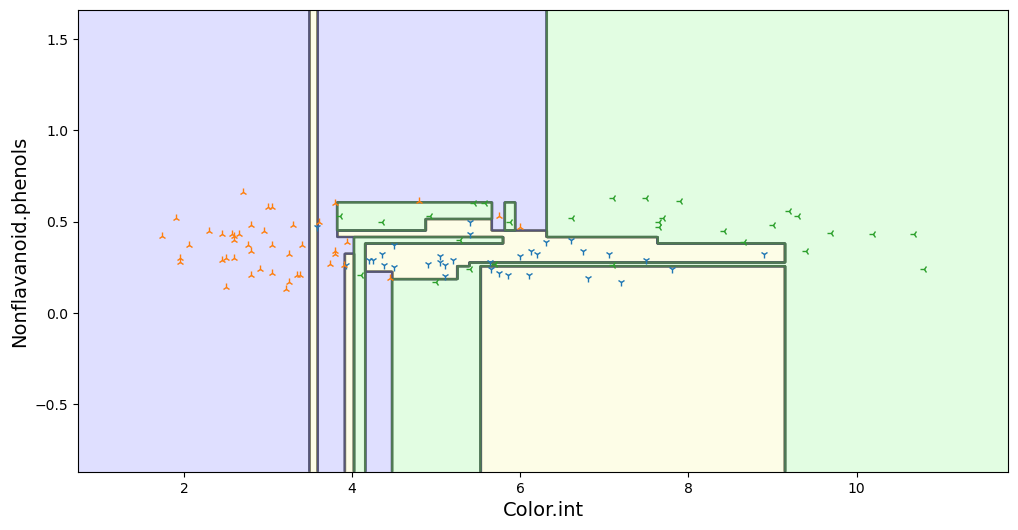

In [357]:
# Representamos gráficamente el límite de decisión construido
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

def plot_decision_boundary(clf, X, y, plot_training=True, resolution=1000):
    mins = X.min(axis=0) - 1
    maxs = X.max(axis=0) + 1
    x1, x2 = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "1", label="1")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "2", label="2")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "3", label="3")
        plt.axis([mins[0], maxs[0], mins[1], maxs[1]])               
    plt.xlabel('Color.int', fontsize=14)
    plt.ylabel('Nonflavanoid.phenols', fontsize=14, rotation=90)

plt.figure(figsize=(12, 6))
plot_decision_boundary(clf_tree_reduced, X_train_reduced.values, y_train)
plt.show()


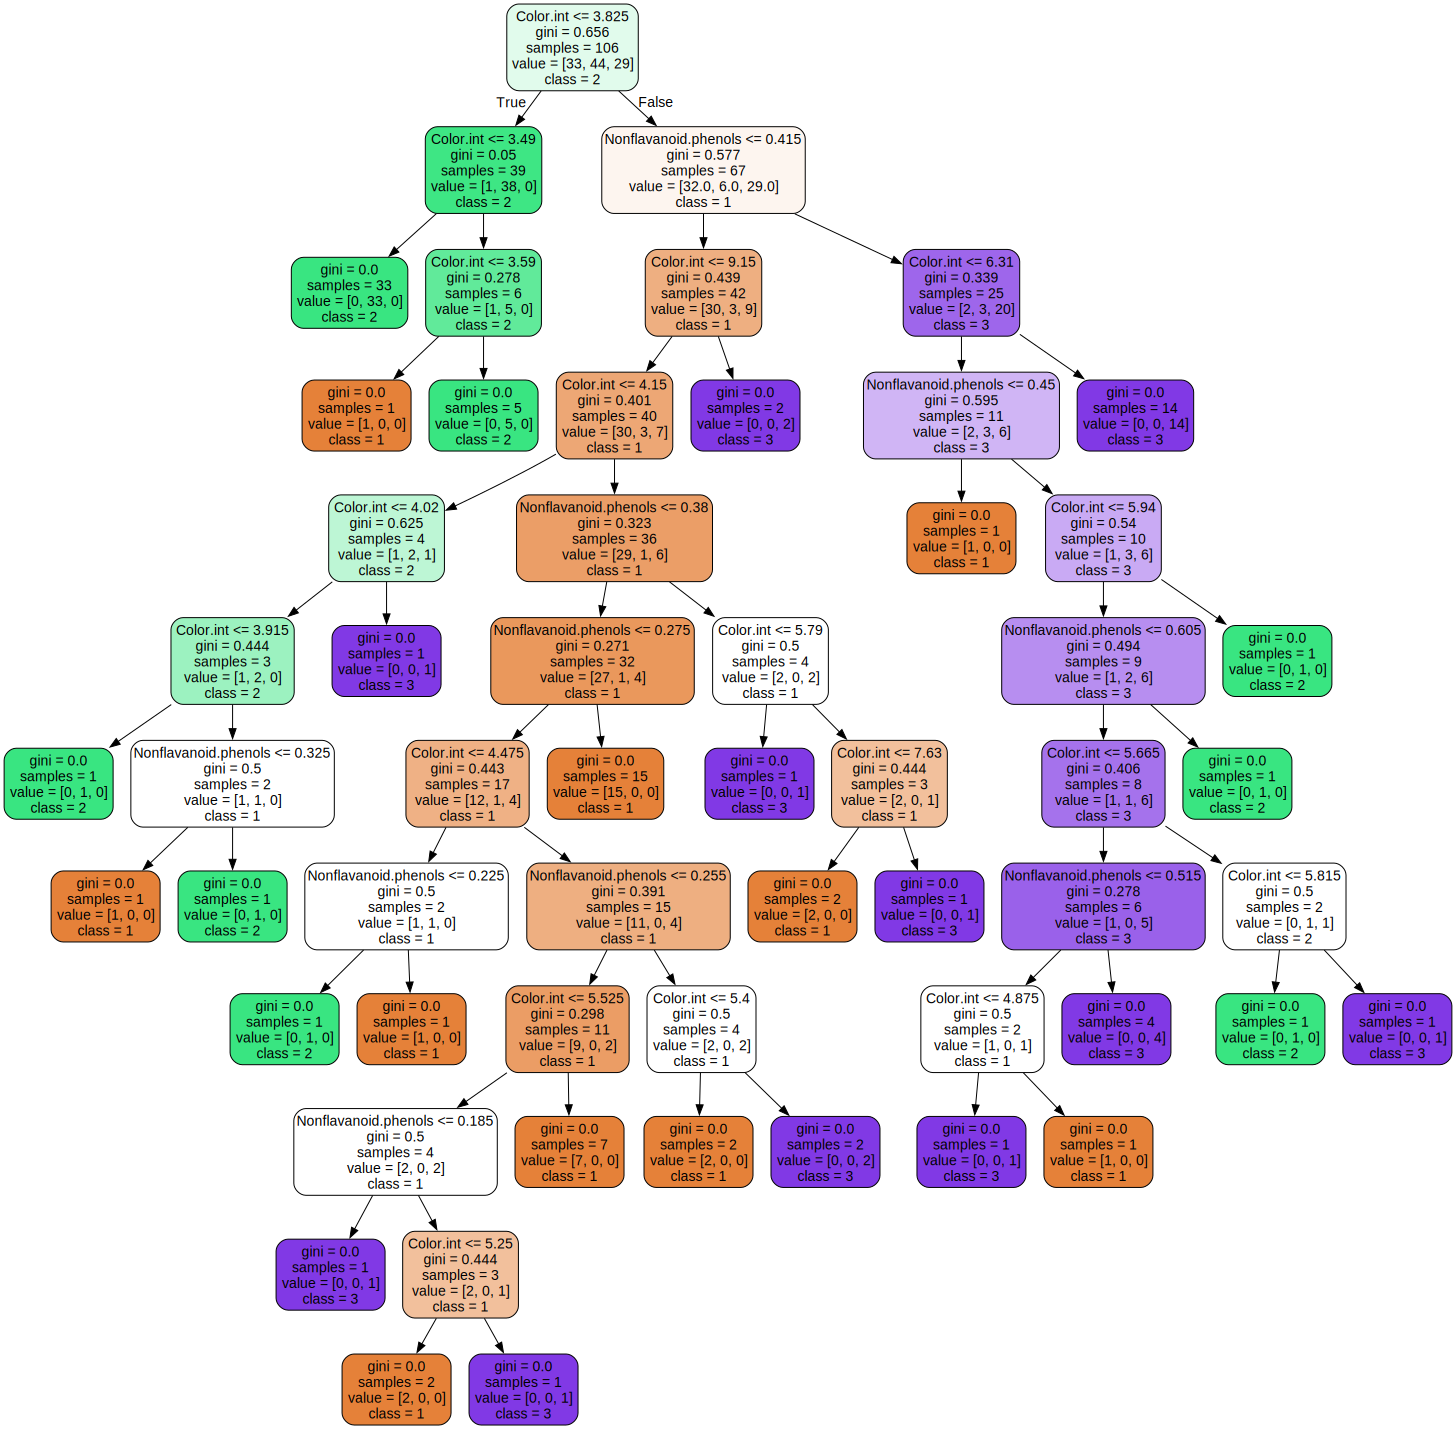

In [358]:
# Pintamos el árbol para compararlo con la representación gráfica anterior
# !pip install graphviz
from graphviz import Source
from sklearn.tree import export_graphviz
import os

export_graphviz(
        clf_tree_reduced,
        out_file="wine.dot",
        feature_names=X_train_reduced.columns,
        class_names=["1", "2", "3"],
        rounded=True,
        filled=True
    )

Source.from_file("wine.dot")

### Random Forest

In [360]:
from sklearn.ensemble import RandomForestClassifier

# Modelo entrenado con el conjunto de datos sin escalar
clf_rnd = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_rnd.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [361]:
# Modelo entrenado con el conjunto de datos escalado
clf_rnd_scaled = RandomForestClassifier(n_estimators=50, max_depth=None, random_state=42, n_jobs=-1)
clf_rnd_scaled.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [362]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred = clf_rnd.predict(X_train)
y_train_prep_pred = clf_rnd_scaled.predict(X_train_scaled)

In [363]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_train_pred, y_train, y_train_prep_pred, y_train, f1_score)

f1_score WITHOUT preparation: 1.0
f1_score WITH preparation: 1.0


In [364]:
# Predecimos con el conjunto de datos de validación
y_pred = clf_rnd.predict(X_val)
y_prep_pred = clf_rnd_scaled.predict(X_val_scaled)

In [365]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_pred, y_val, y_prep_pred, y_val, f1_score)

f1_score WITHOUT preparation: 1.0
f1_score WITH preparation: 1.0
